# Context:
Restaurant inspections for permitted food establishments in NYC. Restaurants are graded on A-C scale with regular visits by city health department.

# Content:
Dataset includes address, cuisine description, inspection date, type, action, violation code and description(s). Data covers all of NYC and starts Jan 1, 2010-Aug 29, 2017.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
import geopandas as gpd
warnings.filterwarnings('ignore')
% pylab inline

Populating the interactive namespace from numpy and matplotlib


First we will load the Restaurant inspection CSV into a pandas dataframe.

In [2]:
df = pd.read_csv('Restaurant_Inspection_Results.csv')
df.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE
0,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016.0,2126863400,Italian,06/15/2015,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140Âº F.,Critical,30.0,NaN,NaN,08/28/2017,Cycle Inspection / Initial Inspection
1,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016.0,2126863400,Italian,11/25/2014,Violations were cited in the following area(s).,20F,Current letter grade card not posted.,Not Critical,NaN,NaN,NaN,08/28/2017,Administrative Miscellaneous / Initial Inspection
2,50046354,VITE BAR,QUEENS,2507,BROADWAY,11106.0,3478134702,Italian,10/03/2016,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,Not Critical,2.0,NaN,NaN,08/28/2017,Pre-permit (Operational) / Initial Inspection
3,50061389,TACK'S CHINESE TAKE OUT,STATEN ISLAND,11C,HOLDEN BLVD,10314.0,7189839854,Chinese,05/17/2017,Violations were cited in the following area(s).,02G,Cold food item held above 41Âº F (smoked fish ...,Critical,46.0,NaN,NaN,08/28/2017,Pre-permit (Operational) / Initial Inspection
4,41516263,NO QUARTER,BROOKLYN,8015,5 AVENUE,11209.0,7187019180,American,03/30/2017,Violations were cited in the following area(s).,04M,Live roaches present in facility's food and/or...,Critical,18.0,NaN,NaN,08/28/2017,Cycle Inspection / Initial Inspection


Now we check the number of rows and columns in the dataframe.

In [3]:
df.shape

(399918, 18)

So we have total of 399918 rows and 18 columns in our dataframe.

The various column datatypes and count of null values is as follows:

In [4]:
for i in df.columns:
    print i, 'has type:',df[i].dtype,'and null values equal to:',df[i].isnull().sum()

CAMIS has type: int64 and null values equal to: 0
DBA has type: object and null values equal to: 359
BORO has type: object and null values equal to: 0
BUILDING has type: object and null values equal to: 109
STREET has type: object and null values equal to: 9
ZIPCODE has type: float64 and null values equal to: 9
PHONE has type: object and null values equal to: 5
CUISINE DESCRIPTION has type: object and null values equal to: 0
INSPECTION DATE has type: object and null values equal to: 0
ACTION has type: object and null values equal to: 1135
VIOLATION CODE has type: object and null values equal to: 6504
VIOLATION DESCRIPTION has type: object and null values equal to: 6979
CRITICAL FLAG has type: object and null values equal to: 0
SCORE has type: float64 and null values equal to: 23214
GRADE has type: object and null values equal to: 204505
GRADE DATE has type: object and null values equal to: 207098
RECORD DATE has type: object and null values equal to: 0
INSPECTION TYPE has type: object 

# Data Preparation and Cleaning

## 1. Deleting unnecessary rows
We first drop all rows with null values in the Action and Inspection Type columns as these rows do not help in our analysis.

In [5]:
df = df.dropna(subset=['ACTION','INSPECTION TYPE'], how='all')
df = df.reset_index(drop=True)
df.shape

(398783, 18)

Now the row count is reduced to 398783. <br>

## 2. Creating Violation_Type Column for analysis
Next I create a lookup table that maps Violation Code to a general Violation Type category with the help of the [ (Chapter 23 of Title 24
of the Rules of
the City of New York) pdf file](http://www1.nyc.gov/assets/doh/downloads/pdf/rii/rii-nyc-rules.pdf) 

In [6]:
code_map = {
    '02':'FOOD TEMPERATURE',
    '03':'FOOD SOURCE',
    '04':'PERSONAL HYGIENE/FOOD PROTECTION',
    '05':'FACILITY DESIGN',
    '06':'PERSONAL HYGIENE/FOOD PROTECTION',
    '08':'VERMIN/GARBAGE',
    '09':'FACILITY MAINTENANCE',
    '10':'FACILITY DESIGN',
    '07':'OTHER',
    '20':'LETTER GRADE CARD/OTHER POSTER ABSENT',
    '16':'MENU DESCRIPTION IMPROPER',
    '22':'OTHER',
    '15':'NO SMOKING POLICY',
    '18':'OTHER',
    'na':'NONE' 
}

Now I create a Violation_Type column using the lookup table.

In [7]:
df['VIOLATION_TYPE'] = df['VIOLATION CODE'].astype(str).str[0:2]
df['VIOLATION_TYPE']=df['VIOLATION_TYPE'].apply(lambda x:code_map[x])

Now I drop the columns VIOLATION CODE AND VIOLATION DESCRIPTION because now we have a simple column VIOLATION_TYPE replacing this. Also I drop the column RECORD DATE because it has only one value 08/28/2017.

In [8]:
df = df.drop(['VIOLATION CODE','VIOLATION DESCRIPTION','RECORD DATE'],axis=1)

## 3. Rectifying the Grades column

The Grades provided by the Health Inspectors are according to the following rule: <br>

<center>
    
| Inspection Score   |   Grade       | 
| :-----------: |---------------| 
|    0-13       | A | 
| 14-27         | B   |  
| >=28 | C     |  
    
<center>
    
Not every time a grade is provided by the Inspector. Sometimes they only provide Score so there are various rows where Score is some finite value but Grade is Null. Also in this dataframe there are grades like P and Z which need to converted to the allowed A, B and C grade category before start of any analysis.


In [9]:
# Function that maps the P and Z grade to correct A, B or C grade
def grades_change(y):
    grade_list = ['A','B','C']
    if (y['GRADE'] in grade_list):
        return y['GRADE']
    elif (y['GRADE']=='P')| (y['GRADE']=='Z'):
        if (y['SCORE']>=0) & (y['SCORE']<=13):
            return 'A'
        elif (y['SCORE']>=14) & (y['SCORE']<=27):
            return 'B'
        else:
            return 'C'

In [10]:
df['GRADE'] = df.apply(grades_change,axis=1)
# After converting the grades to their correct class let's just check the final counts of them
df['GRADE'].value_counts()

A    155838
B     29383
C      7593
Name: GRADE, dtype: int64

## 4. Coverting ZIPCODE to String format

In [11]:
df['ZIPCODE'] = df['ZIPCODE'].astype(int).astype(str)

# Data Analysis

## 1. Summary Statistics
First we get the **Total number of Restaurants** in this dataframe

In [12]:
df['CAMIS'].nunique()

25370

So there are total 25,370 restaurants in our dataframe.<br>

Let us now try to know their distribution according to Cuisine type.

Text(0,0.5,u'Number of Restaurants')

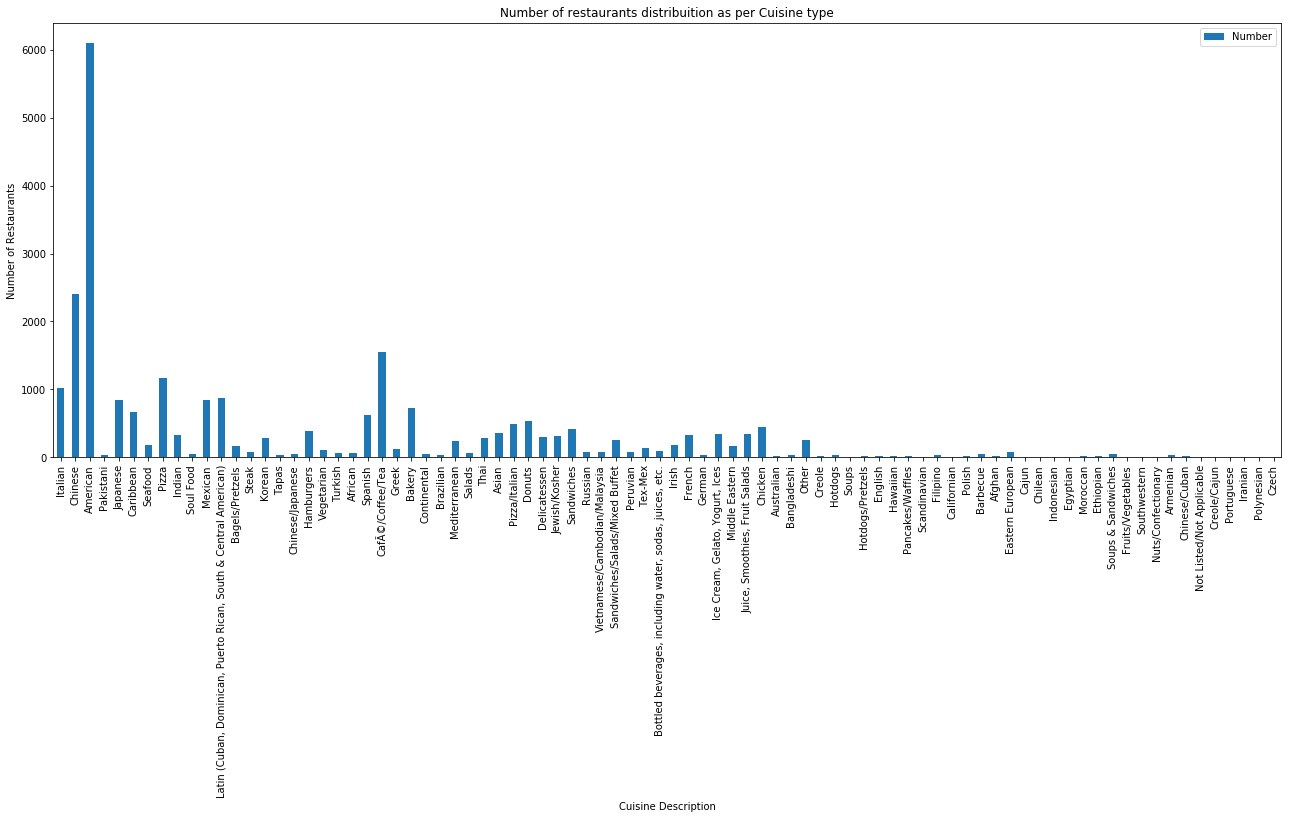

In [13]:
cus = []
cus_n = []
for i in df["CUISINE DESCRIPTION"].unique():
    cus.append(i)
    cus_n.append(df[df["CUISINE DESCRIPTION"]==i]["CAMIS"].nunique())
df_cus = { 'Cuisine Description':cus,'Number':cus_n}
df_cus = pd.DataFrame(df_cus)
df_cus.plot(x="Cuisine Description", y=["Number"], kind="bar",figsize=(22,8))
plt.title('Number of restaurants distribuition as per Cuisine type')
plt.ylabel('Number of Restaurants')

From the above plot we see that the top 2 Cuisine types with the largest number of Restaurants are : <br>
 1. American
 2. Chinese

Now let us know the distribution of Restaurants according to Boroughs.

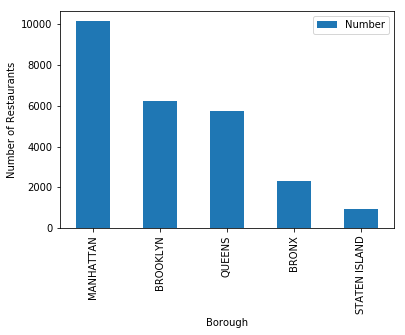

In [14]:
bor = []
bor_n = []
for i in df["BORO"].unique():
    bor.append(i)
    bor_n.append(df[df["BORO"]==i]["CAMIS"].nunique())
df_bor = { 'Borough':bor,'Number':bor_n}
df_bor = pd.DataFrame(df_bor)
df_bor = df_bor.sort_values(['Number'],ascending=[0])
df_bor.reset_index(drop=True,inplace=True)
df_bor.plot(x=["Borough"], y=["Number"], kind="bar",figsize=(6,4))
plt.ylabel('Number of Restaurants')
plt.show()

We see that Manhattan has the highest and Staten Island the lowest number of Restaurants. <br>
## 2. Grades & Score distribution
Let us now check the distribution of Grades across the different boroughs.

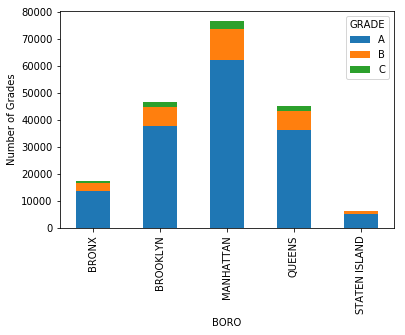

In [15]:
df2 = df.groupby(['BORO', 'GRADE'])['BORO'].count().unstack('GRADE').fillna(0)
df2[['A','B','C']].plot(kind='bar', stacked=True)
plt.ylabel('Number of Grades')
plt.show()

From the above plot we see that the mostly the grades are A and only few B and C grades are present. Also we see that the performance of the restaurants doesn't vary that much with boroughs. Now let us check the Inspection scores with Borough.

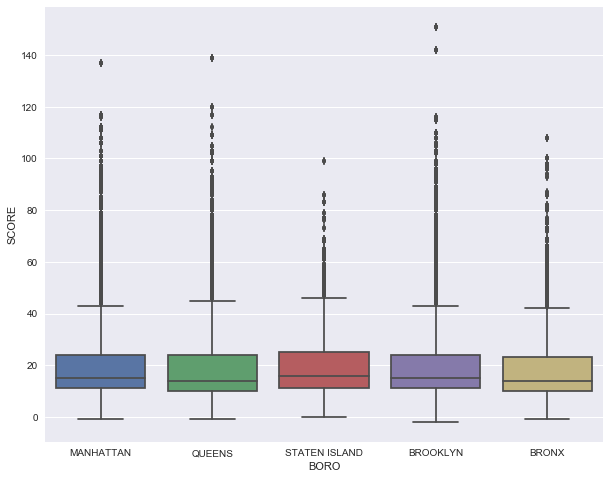

In [16]:
import seaborn as sns
sns.set(rc={'figure.figsize':(10,8)})
sns.boxplot(x='BORO',y='SCORE',data=df)

The results are similar to the result for the Grades distribution.

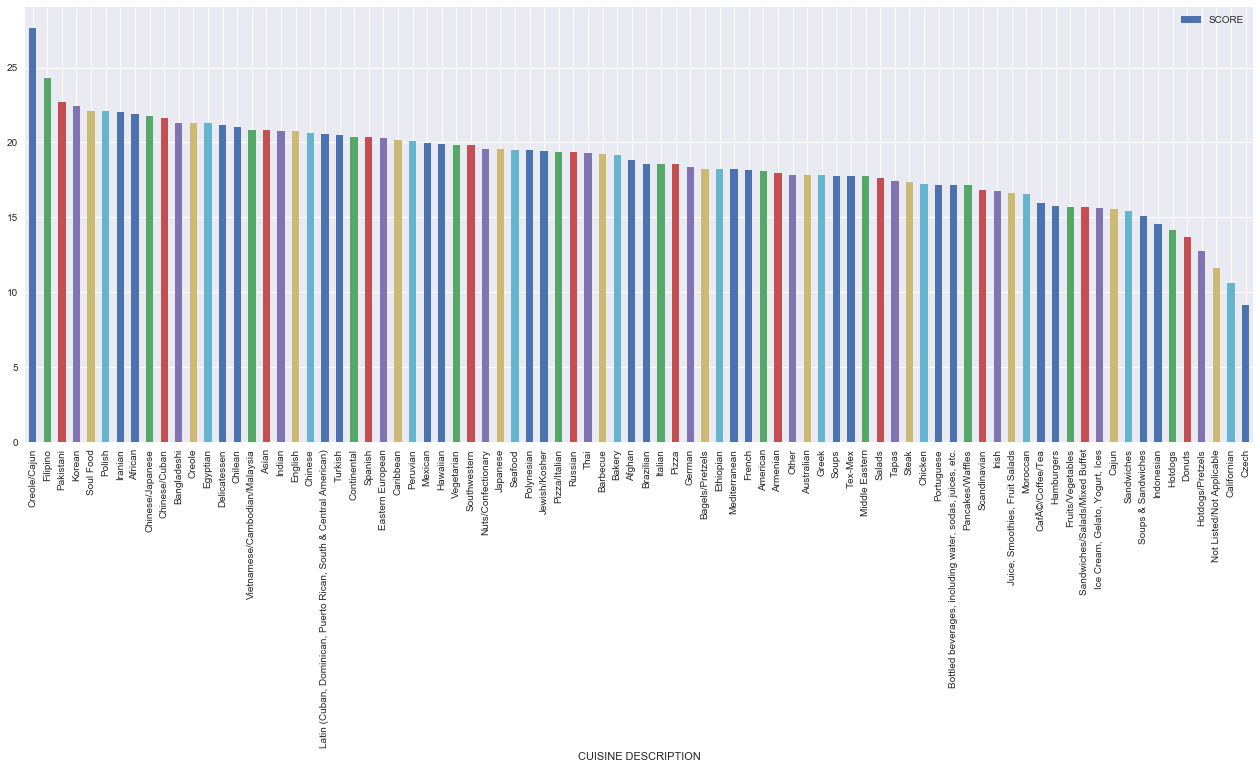

In [17]:
#Now let us check the distribution of Average Scores across Cuisine Types
df_c = df.groupby(['CUISINE DESCRIPTION'],as_index=False)['SCORE'].mean()
df_c.sort_values(by='SCORE', ascending=False, inplace=True)
df_c.reset_index(drop=True,inplace=True)
df_c.plot.bar(x='CUISINE DESCRIPTION', y='SCORE',figsize=(22,8))

From the above plot it is seen that the top most violators among Cuisine are:
    1. Cajun
    2. Filipino
    
And the safest Cuisine are:
    1. Czech
    2. Californian

## 3. Analysis of Violation Types

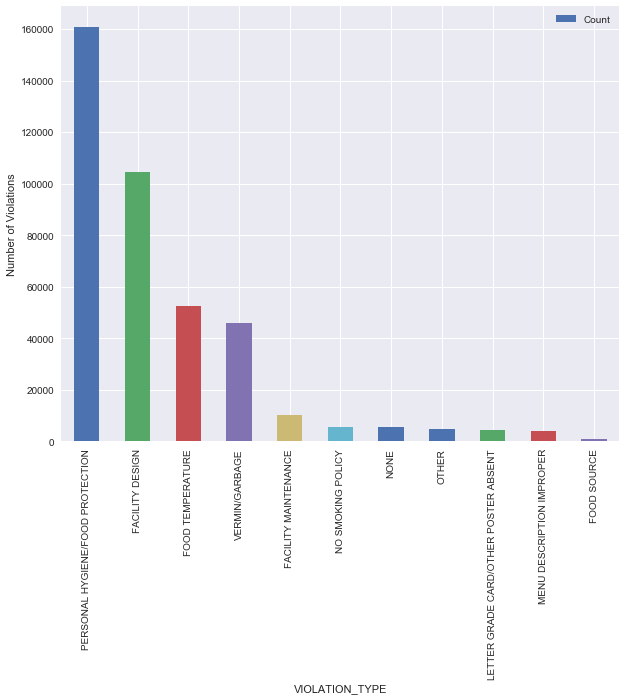

In [18]:
#Now let us check the distribution of Violation Types
df_v = df.groupby(['VIOLATION_TYPE'],as_index=False)['CAMIS'].count()
df_v.rename(columns={'CAMIS': 'Count'}, inplace=True)
df_v.sort_values(by='Count', ascending=False, inplace=True)
df_v.reset_index(drop=True,inplace=True)
df_v.plot.bar(x='VIOLATION_TYPE', y='Count')
plt.ylabel('Number of Violations')
plt.show()

So the above plot tells us that the major violations are due to improper handling of food and improper restaurant design not in compliance with food standards. <br>
## 4. Restaurant Closings
Let us now analyse the Restaurants closed by the Health Inspectors.

In [19]:
df_closed = df[df['ACTION'].str.contains("Establishment Closed|Establishment re-closed")]
print 'Total Number of times Restaurants closed by the Health Inspectors are',df_closed['ACTION'].count()

Total Number of times Restaurants closed by the Health Inspectors are 10065


Now let us see ditribution of Violation codes for such

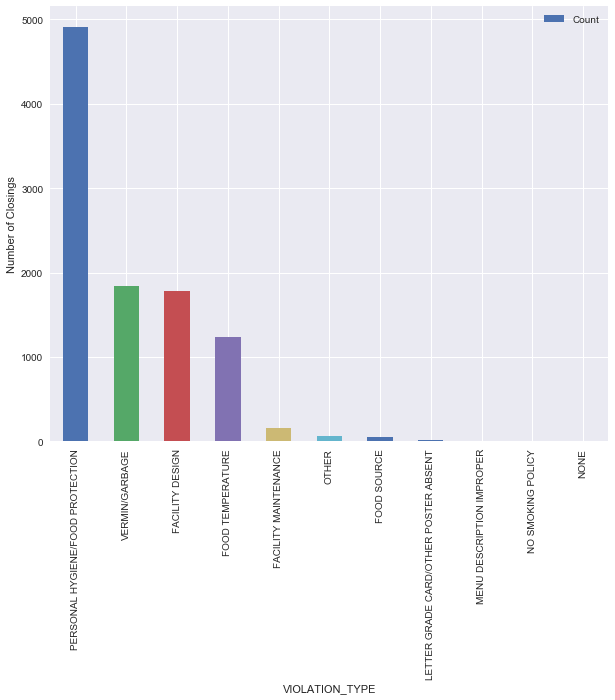

In [20]:
df_cr = df_closed.groupby(['VIOLATION_TYPE'],as_index=False)['CAMIS'].count()
df_cr.rename(columns={'CAMIS': 'Count'}, inplace=True)
df_cr.sort_values(by='Count', ascending=False, inplace=True)
df_cr.reset_index(drop=True,inplace=True)
df_cr.plot.bar(x='VIOLATION_TYPE', y='Count')
plt.ylabel('Number of Closings')
plt.show()

So the two main reasons for closing are :
    1. Improper handling of food and not maintaning proper hygiene
    2. Garbage handling not proper

Let us now see distribution of closed restaurants over Cuisine type

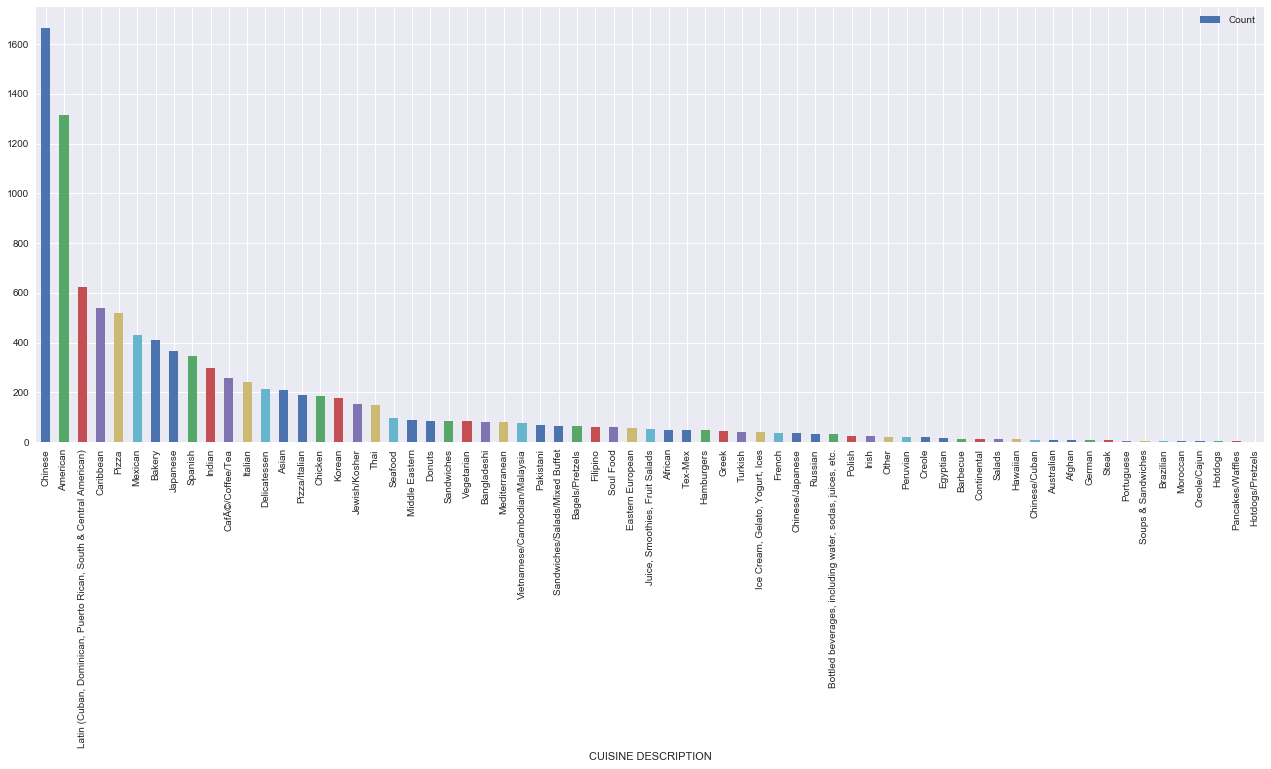

In [21]:
df_cct = df_closed.groupby(['CUISINE DESCRIPTION'],as_index=False)['CAMIS'].count()
df_cct.rename(columns={'CAMIS': 'Count'}, inplace=True)
df_cct.sort_values(by='Count', ascending=False, inplace=True)
df_cct.reset_index(drop=True,inplace=True)
df_cct.plot.bar(x='CUISINE DESCRIPTION', y='Count',figsize=(22,8))

From the above plot we see that even though Chinese have been closed the most number of times followed by American cuisine restaurant. Even though Chinese resturants are much small in number than American restaurants they still close at a much higher rate than American ones. <br>

A surprising fact is that these Cuisine types didn't occur much up the order when their average score were plotted.

## 5. Choropleth Maps

We plot the average Score per zip code as a choropleth map to check their distribution with the help of visual analysis on a map.

Text(0.5,1,u'NYC Restaurants Health Score distribution as per Zipcode')

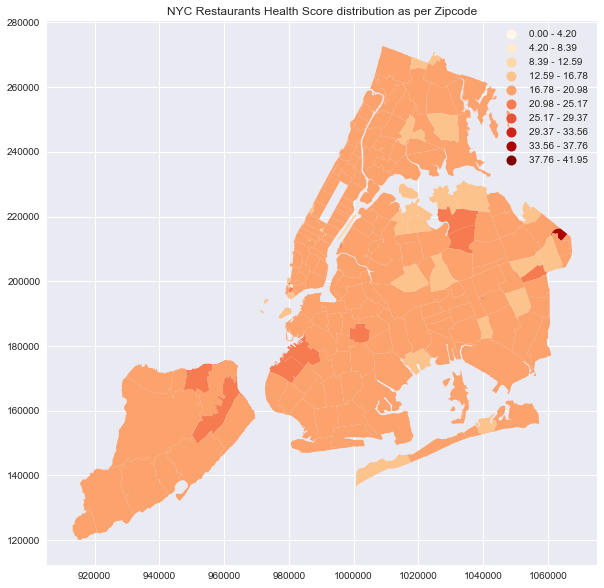

In [22]:
gdf = gpd.read_file('ZIP_CODE_040114/ZIP_CODE_040114.shp')
gdf = gdf[['ZIPCODE','geometry']]
df_z= df.groupby(['ZIPCODE'],as_index=False)['SCORE'].mean()
merged = gdf.merge(df_z, left_on='ZIPCODE', right_on='ZIPCODE')
merged.plot(column='SCORE',figsize=(20,10),scheme='equal_interval', k=10, legend=True,cmap='OrRd')
plt.title('NYC Restaurants Health Score distribution as per Zipcode')

We see only a few patches of high score among a few zipcodes. Most of the zipcodes have low scores.